In [48]:
#uncomment to clean up the variables
%reset -f

In [49]:
#change the folder to your default installation folder
folder = '/Users/matteoferro/Library/Python/3.9/lib/python/site-packages/pyetc_dev/'

from pyetc_dev import *
import os
import matplotlib.pyplot as plt
from astropy import constants
import skycalc_ipy
from mpdaf.obj import Spectrum
#from astropy import constants

import warnings
warnings.filterwarnings('ignore')

#this is a package of mine for plot quality, comment it and the following row in case you use this notebook 
from setplot import set_plot_style
set_plot_style()

In [50]:
### set up the container
obj = WST(log = 'DEBUG', skip_dataload = False)

In [51]:
#SPEC = template, pl, bb, line

#SP_BIN = binning of the spectral trace, integer

#TEMP_NAME is the name of the template, you can list them with sed_models.eso_spectra_files.keys()

################ only for line #############################
#SPEC_range = fixed, adaptative, None

#### only for fixed ####
#SPEC_HSIZE = 5 [range will be 2 * SPEC_HSIZE + 1]
########################

#### only for adaptative ####
#SPEC_KFWHM = 3 [range will be +- SPEC_KFWHM]
#OPT_SPEC = True, to compute the best SPEC_KFWHM for the maximization of the SNR
#############################
############################################################


#OBJ = sb, ps, resolved

################ only for resolved ###############################
#IMA = moffat, sersic 

#IMA_ELL = 0.

#### only for moffat ####
#IMA_FWHM = 1. in arcsec
#IMA_BETA = 2.5 in arcsec
#IMA_KFWHM = 3 by default
#########################

#### only for sersic ####
#IMA_REFF = 1. in arcsec
#IMA_N = 2.
#IMA_KREFF = 6 by default
#########################

##################################################################

################ only for sb ###############################
#IMA_AREA = 1. arcsec, area to use for the SNR computation
############################################################

################ only for ps and resolved ##################
#IMA_RANGE = circular_adaptative, square_fixed

#### only for square_fixed ####
#IMA_HSIZE = 5 [range will be 2 * IMA_HSIZE + 1] #INTEGER
###############################

#### only for circular_adaptative ####
#IMA_KFWHM = 3 [range will be +- IMA_KFWHM]
#OPT_IMA = True, to compute the best IMA_KFWHM for the maximization of the SNR
######################################
############################################################

### "SKYCALC": if false it uses the default configurations in the folder using MOON, 
###true it computes the sky with a call to the ESO Skycalc and want the FLI and PWV parameters

# SNR & SNR_WAVE are the target SNR at a specific wave if you want to compute the NDIT or DIT

#Here an example of how it should be

full_obs = {
    "INS": "ifs",
    "CH": "red",
    
    "NDIT": 5,
    "DIT": None, 
    
    "SNR": 10,
    "SNR_WAVE":7000,
    
    "MOON": 'greysky',
    "PWV": 10,
    "FLI": 0,
    "SEE": 0.8,
    "AM": 1.16,
    "SKYCALC": True,
    
    "SPEC": 'bb',
    "TEMP_NAME": None,
    
    "MAG": 20,
    "SYS": 'AB',
    "FIL": 'iSDSS',
    
    "Z": 0,
    "TEMP": 11000.,
    "INDEX": -2.,
    
    "FLUX": 50e-16,
    "WAVE_CENTER": 7000,
    "WAVE_FWHM":20,
    
    "OBJ": 'resolved',
    
    "IMA": 'sersic',
    "IMA_ELL": 0.,
    
    "IMA_FWHM": 1.,
    "IMA_BETA": 999,
    "IMA_KFWHM": 10,
    
    "IMA_REFF": 8.00,
    "IMA_N": 4.00,
    "IMA_KREFF": 5,
    
    "SPEC_RANGE": 'fixed',
    "SPEC_KFWHM": 10,
    "SPEC_HSIZE": 30,
    
    "SP_BIN": 1,
    
    "IMA_AREA": (1*0.2)**2,
    "IMA_RANGE": 'square_fixed',
    "IMA_HSIZE": 1,
    
    "OPT_SPEC": False,
    "OPT_IMA": False,
    "FRAC_SPEC_MEAN_OPT_IMAGE": 1
}

ifs blue: wave ≈ 5499.7 Å → FWHM = 0.742 arcsec
ifs red: wave ≈ 6000.0 Å → FWHM = 0.725 arcsec
moshr U: wave ≈ 4000.0 Å → FWHM = 0.856 arcsec
moshr B: wave ≈ 5332.0 Å → FWHM = 0.800 arcsec
moshr V: wave ≈ 6431.0 Å → FWHM = 0.765 arcsec
moshr I: wave ≈ 8380.0 Å → FWHM = 0.717 arcsec
moslr blue: wave ≈ 5349.8 Å → FWHM = 0.799 arcsec
moslr orange: wave ≈ 5499.8 Å → FWHM = 0.794 arcsec
moslr red: wave ≈ 7200.0 Å → FWHM = 0.744 arcsec


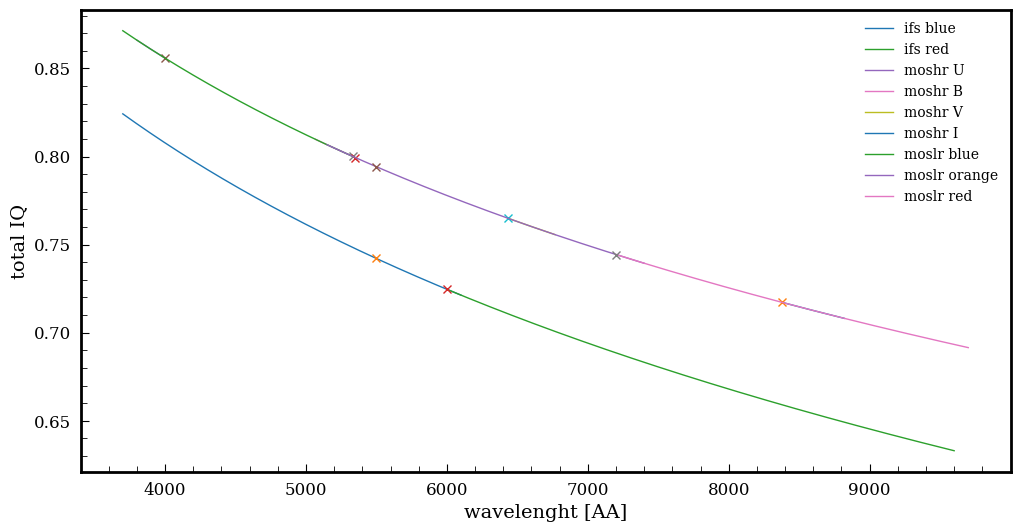

In [52]:
from pyetc_dev.etc import get_seeing_fwhm, show_noise
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

#change this to see how it changes the IQ
#! ! ! QUI A TENTATIVI PER VEDERE CHE SEEING DEVO METTERE NEL MIO DIZIONARIO PER AVERE UNA CERTA IQ_FWHM (TENGO 1)
seeing = full_obs['SEE']
airmass = full_obs['AM']

for ins in [obj.ifs, obj.moshr, obj.moslr]:
    for chan in ins['channels']:
        inst = ins[chan]
        wave = inst['wave'].coord()
        fwhm = get_seeing_fwhm(seeing, airmass, wave, obj.tel['diameter'], inst['iq_fwhm_tel'], inst['iq_fwhm_ins'])[0]
        ax.plot(wave, fwhm, label=f"{inst['name']} {chan}")
        
        #reference wave
        X = 5500.00
        idx = np.argmin(np.abs(wave - X))
        closest_wave = wave[idx]
        fwhm_at_X = fwhm[idx]
        
        ax.plot(closest_wave, fwhm_at_X, marker='x')
        print(f"{inst['name']} {chan}: wave ≈ {closest_wave:.1f} Å → FWHM = {fwhm_at_X:.3f} arcsec")
ax.legend()
ax.set_ylabel('total IQ')
ax.set_xlabel('wavelenght [AA]');

In [53]:
con, ob, spe, im, spe_input = obj.build_obs_full(full_obs)

In [54]:
res_time = obj.time_from_source(con, im, spe, dit=True)

Computed DIT: 1658.84 > 1659.00 for target SNR: 10.00 at wavelength 7000.00 A, in 9 spaxels
% % % Computing fraction of saturated pixels % % %
Fraction of saturated voxels: 1.1% for saturation level 65000.00 counts
[DEBUG] Source type resolved & cont
Time elapsed: 0.13 seconds


In [55]:
res_snr = obj.snr_from_source(con, im, spe)

[DEBUG] Source type resolved & cont Flux 1.00e+00 S/N 6.3 FracFlux 0.032 Nspaxels 9 Nspectels 1
Time elapsed: 1.53 seconds


In [56]:
res_time

{'dit': 1659.0, 'frac_sat': 0.011045258620689655, 'ndit': 5}

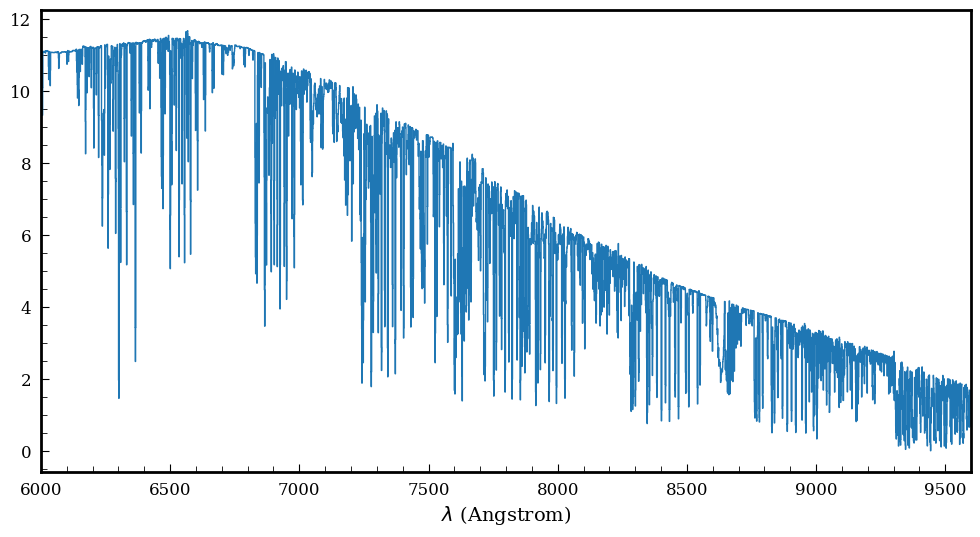

In [57]:
res_snr['spec']['snr'].plot()

In [58]:
e_dit = res_snr['spec']['nph_source']
e_dit /= ob['ndit']

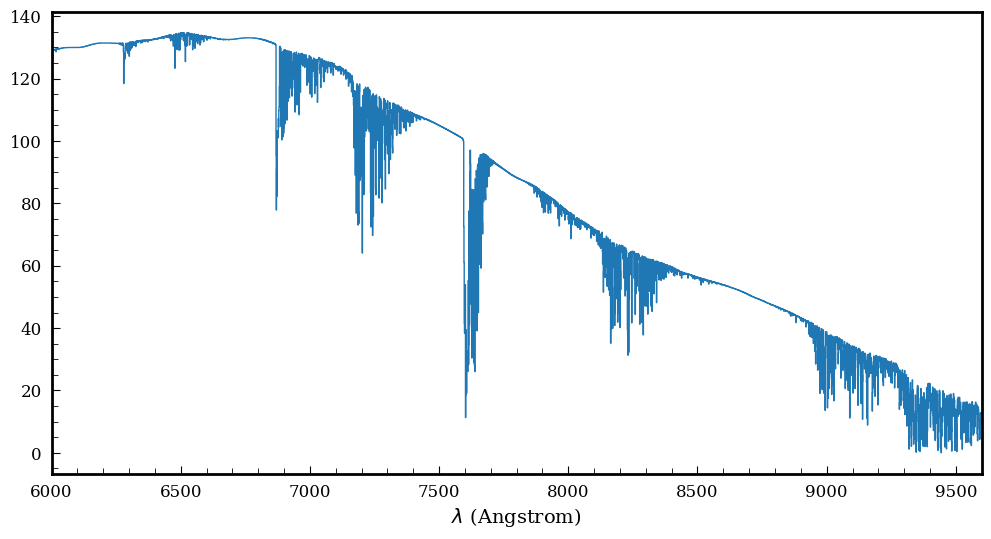

In [59]:
e_dit.plot()